## Final Project Submission

Please fill out:
* Student name: Brian Caterfino
* Student pace: full time
* Scheduled project review date/time: 4:40 pm 1/16
* Instructor name: Rafael
* Blog post URL:


# Building a position classifier based on NBA players' seasonal averages

### The NBA is unique among the major sports leagues in the fact that its players positions are defined loosely. Some basketball analysts believe basketball is truely positionless, and that the current classification system is antiquated, a relic of an older era. To test this hypothesis, I will build a classifier, using their season statistics to group the players by position and observe the accuracy and performance of the classifier. The easier it is to classify these players into well defined positions, the better the case for positional basketball being alive and well.

## 1) Background information

### For those not familiar with NBA positions, I will attempt to give a breakdown, based on common perceptions of what each position entails. 

### The point guard / PG / 1

#### The Point Guard is the smallest player on the team, dribbles the ball up the court on offense, and racks up assists, points, and turnovers. Stays pretty far away from the basket.

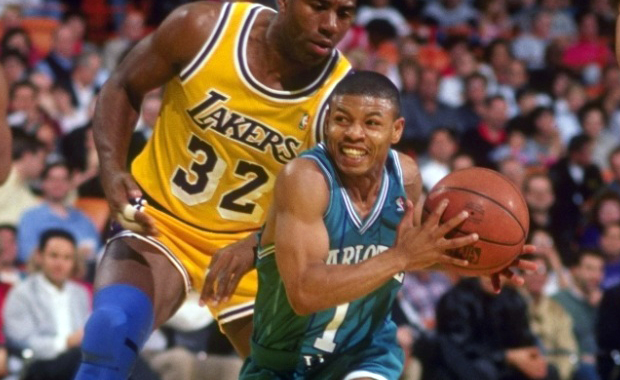

### The Shooting guard / SG / 2

#### The Shooting Guard is usually the second smallest player on the team, the best shooter, is usually far away from the basket, and specializes in points and 3PA.

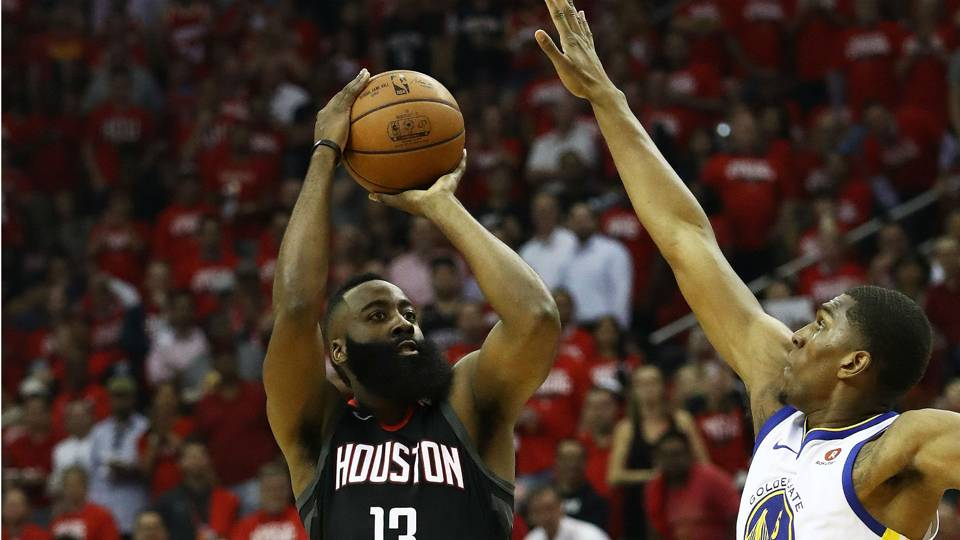

### The Small Forward / SF / 3

#### The Small forward is the midsized player that can be found anywhere on the court and counting stats can be evenly distributed.

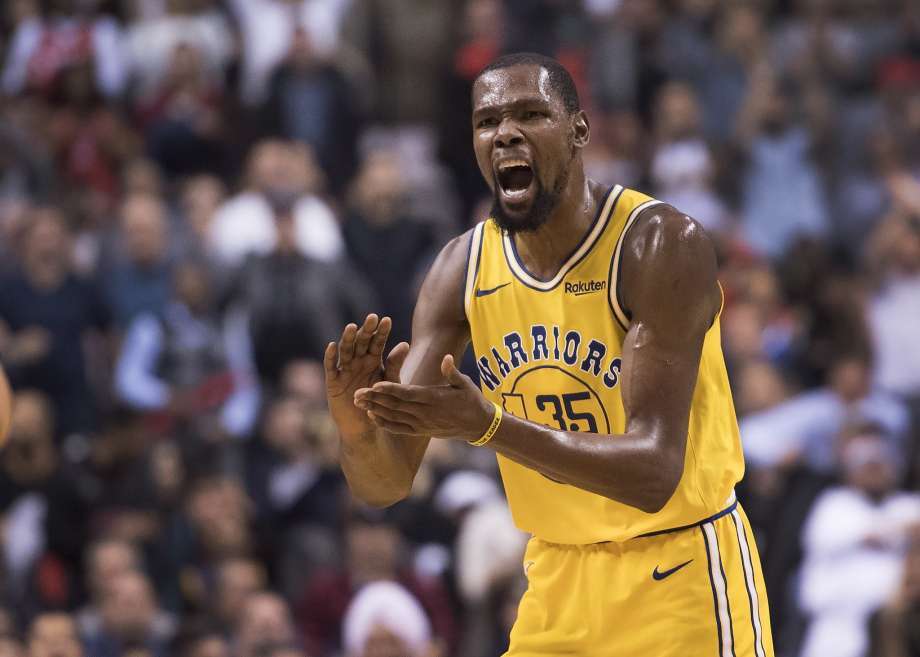

### The Power Forward / PF / 4

#### The power forward is a mix of power and speed, can be found under the basket, but has extended range compared to the center. Usually colects rebounds and points.

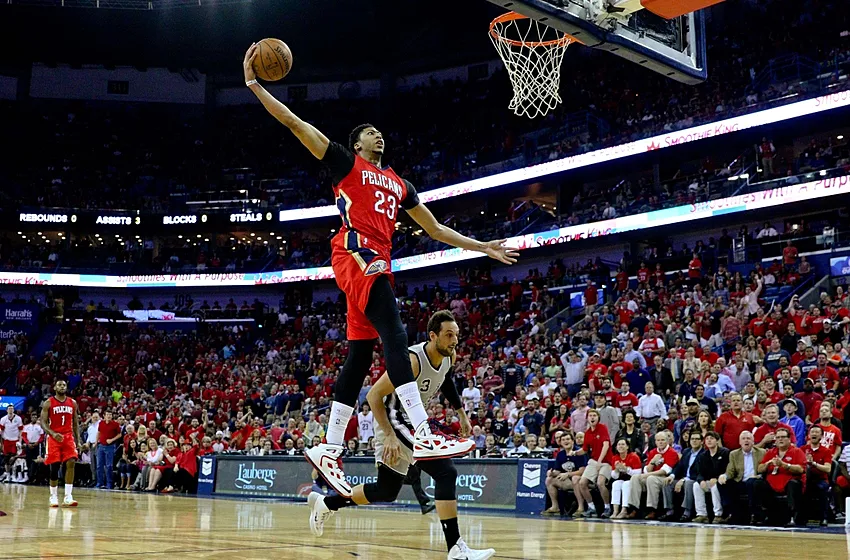

### The Center / C / 5

#### The center is the biggest player on the court, stands near the basket, and usually collects rebounds and blocks.

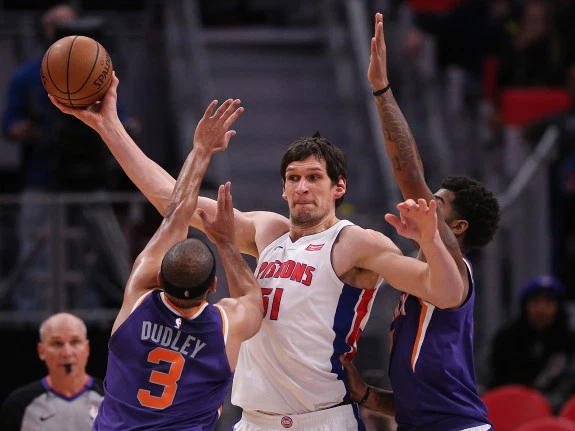

## 2) Importing libraries and data

In [1]:
import pandas as pd
import numpy as np
from pandas import ExcelWriter
from pandas import ExcelFile
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import calinski_harabaz_score
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import warnings
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn import datasets
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import confusion_matrix


C:\Users\Brian\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
C:\Users\Brian\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### Importing data from BasketballReference.com into dataframes per year over the last 10 years

In [2]:
df19 = pd.read_csv(r"C:\Users\Brian\Desktop\DS\NBASTATS19.csv")
df18 = pd.read_csv(r"C:\Users\Brian\Desktop\DS\NBASTATS18.csv")
df17 = pd.read_csv(r"C:\Users\Brian\Desktop\DS\NBASTATS17.csv")
df16 = pd.read_csv(r"C:\Users\Brian\Desktop\DS\NBASTATS16.csv")
df15 = pd.read_csv(r"C:\Users\Brian\Desktop\DS\NBASTATS15.csv")
df14 = pd.read_csv(r"C:\Users\Brian\Desktop\DS\NBASTATS14.csv")
df13 = pd.read_csv(r"C:\Users\Brian\Desktop\DS\NBASTATS13.csv")
df12 = pd.read_csv(r"C:\Users\Brian\Desktop\DS\NBASTATS12.csv")
df11 = pd.read_csv(r"C:\Users\Brian\Desktop\DS\NBASTATS11.csv")
df10 = pd.read_csv(r"C:\Users\Brian\Desktop\DS\NBASTATS10.csv")

In [3]:
df12.head(3)

Rk         Player         ID Pos  Age   Tm   G  GS    MP   FG ...     FT%  \
0   1    Jeff Adrien  adrieje01  PF   25  HOU   8   0    63    7 ...   0.583   
1   2  Arron Afflalo  afflaar01  SG   26  DEN  62  62  2086  329 ...   0.798   
2   3   Blake Ahearn  ahearbl01  PG   27  UTA   4   0    30    4 ...     NaN   

   ORB  DRB  TRB  AST  STL  BLK  TOV   PF  PTS  
0    5   17   22    1    0    2    2   13   21  
1   40  157  197  149   36   13   85  134  943  
2    0    2    2    1    0    0    5    4   10  

[3 rows x 31 columns]

## 3) Exploratory Data Analysis

### In this stage I aim to preprocess the data and make it suitable for feture selectin and modelling

#### To account for some players being traded mid-season, I create unique label based on the player name, year, and team.

In [4]:
df10['ID2']= df10['ID'] + "2010" + df10['Tm']
df11['ID2']= df11['ID'] + "2011" + df11['Tm']
df12['ID2']= df12['ID'] + "2012" + df12['Tm']
df13['ID2']= df13['ID'] + "2013" + df13['Tm']
df14['ID2']= df14['ID'] + "2014" + df14['Tm']
df15['ID2']= df15['ID'] + "2015" + df15['Tm']
df16['ID2']= df16['ID'] + "2016" + df16['Tm']
df17['ID2']= df17['ID'] + "2017" + df17['Tm']
df18['ID2']= df18['ID'] + "2018" + df18['Tm']
df19['ID2']= df19['ID'] + "2019" + df19['Tm']

#### Now I create my master dataframe of all ten years combined. Then I add a stat I belive may be useful, which is Assists/Turnovers

In [5]:
dfall= pd.concat([df10, df11, df12, df13, df14, df15, df16, df17, df18, df19])
dfall['AST/TOV']= dfall['AST']/ dfall['TOV']
df1=dfall

In [6]:
dfall.shape

(5930, 33)

In [7]:
dfall.columns

Index(['Rk', 'Player', 'ID', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA',
       'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA',
       'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
       'ID2', 'AST/TOV'],
      dtype='object')

In [8]:
dfall.head(3)

Rk             Player         ID Pos  Age   Tm   G  GS    MP   FG  \
0   1      Arron Afflalo  afflaar01  SG   24  DEN  82  75  2221  272   
1   2      Alexis Ajinca  ajincal01   C   21  CHA   6   0    30    5   
2   3  LaMarcus Aldridge  aldrila01  PF   24  POR  78  78  2922  579   

     ...     DRB  TRB  AST  STL  BLK  TOV   PF   PTS               ID2  \
0    ...     193  252  138   46   30   74  225   724  afflaar012010DEN   
1    ...       3    4    0    1    1    2    5    10  ajincal012010CHA   
2    ...     435  627  160   67   48  104  231  1393  aldrila012010POR   

    AST/TOV  
0  1.864865  
1  0.000000  
2  1.538462  

[3 rows x 33 columns]

#### I remove all player's seasons who did not play 48 minutes or more. 48 minutes is equivalent to one full games minutes, and this is to ensure an ample sample size for each player's season.

In [9]:
df=dfall.loc[dfall['MP']>=48]

In [10]:
df.shape

(5441, 33)

### Now to deal with null values in my columns. I check all null values in the database

In [11]:
df.isna().sum()

Rk           0
Player       0
ID           0
Pos          0
Age          0
Tm           0
G            0
GS           0
MP           0
FG           0
FGA          0
FG%          0
3P           0
3PA          0
3P%        578
2P           0
2PA          0
2P%          2
eFG%         0
FT           0
FTA          0
FT%         54
ORB          0
DRB          0
TRB          0
AST          0
STL          0
BLK          0
TOV          0
PF           0
PTS          0
ID2          0
AST/TOV      1
dtype: int64

### It seems like all the null values are the percentage stats for players that have 0 attempts. Since the total number of null values is relatively small, I will replace all null values with zero.

In [12]:
df['FT%'].fillna(value=0, inplace=True)
df['3P%'].fillna(value=0, inplace=True)
df['2P%'].fillna(value=0, inplace=True)
df['AST/TOV'].fillna(value=0, inplace=True)

C:\Users\Brian\Anaconda3\lib\site-packages\pandas\core\generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [13]:
df.head(3)

Rk             Player         ID Pos  Age   Tm   G  GS    MP   FG  \
0   1      Arron Afflalo  afflaar01  SG   24  DEN  82  75  2221  272   
2   3  LaMarcus Aldridge  aldrila01  PF   24  POR  78  78  2922  579   
4   5        Malik Allen  allenma01  PF   31  DEN  51   3   456   46   

     ...     DRB  TRB  AST  STL  BLK  TOV   PF   PTS               ID2  \
0    ...     193  252  138   46   30   74  225   724  afflaar012010DEN   
2    ...     435  627  160   67   48  104  231  1393  aldrila012010POR   
4    ...      46   82   16   11    5   22   68   105  allenma012010DEN   

    AST/TOV  
0  1.864865  
2  1.538462  
4  0.727273  

[3 rows x 33 columns]

In [14]:
range(len(df))


range(0, 5441)

### There are a few players who have never committed a turnover, and therefore have an infinite AST/TOV ratio. Since there are only a few, I will simply remove them from the dataset.

In [15]:
df =df.loc[df['AST/TOV']<10]

### Now to seperate the data into features and the target variable (Position) and remove categorical data types

In [16]:
target= df['Pos']
data= df

data.pop('Player')
data.pop('Pos')
data.pop('ID')
data.pop('ID2')
data.pop('Tm')
data.head()

Rk  Age   G  GS    MP   FG   FGA    FG%   3P  3PA    ...     ORB  DRB  TRB  \
0   1   24  82  75  2221  272   585  0.465  108  249    ...      59  193  252   
2   3   24  78  78  2922  579  1169  0.495    5   16    ...     192  435  627   
4   5   31  51   3   456   46   116  0.397    1    6    ...      36   46   82   
5   6   34  80  80  2819  464   973  0.477  145  399    ...      45  208  253   
6   7   28  54   8   889  129   253  0.510    0    5    ...      52   93  145   

   AST  STL  BLK  TOV   PF   PTS   AST/TOV  
0  138   46   30   74  225   724  1.864865  
2  160   67   48  104  231  1393  1.538462  
4   16   11    5   22   68   105  0.727273  
5  210   64   25  129  182  1304  1.627907  
6   72   59   19   66  109   330  1.090909  

[5 rows x 28 columns]

In [17]:
data.shape
features = ['Rk',  'Age',  'G', 'GS', 'MP', 'FG', 'FGA',
       'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA',
       'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'AST/TOV']

### Histograms are a good way to get a quick visualization of the distribution of the features

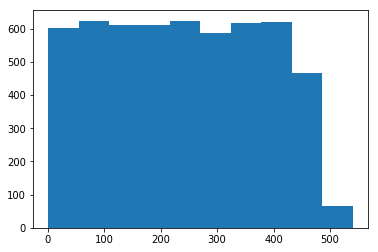

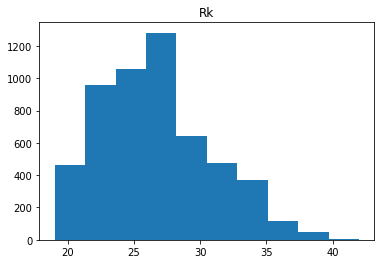

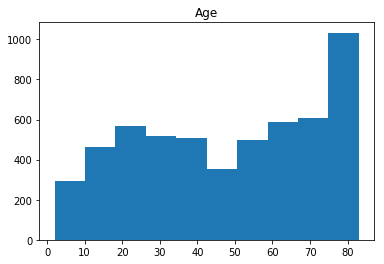

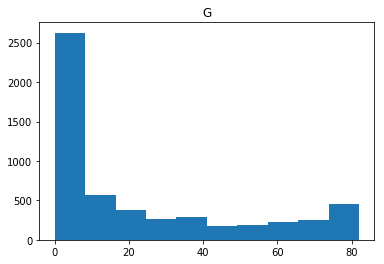

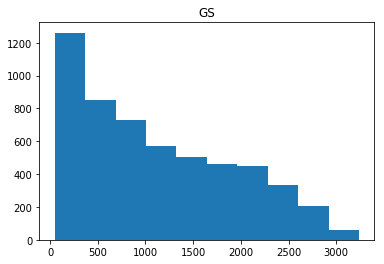

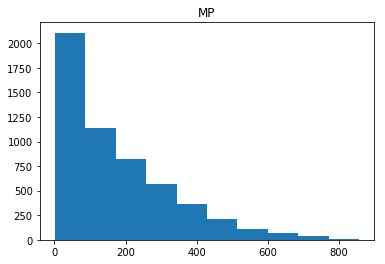

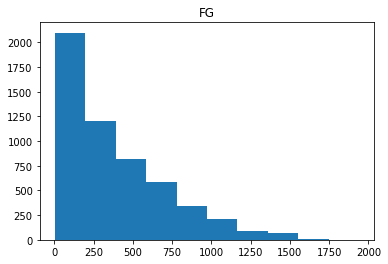

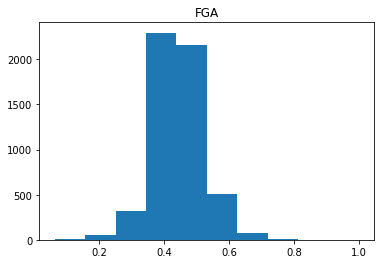

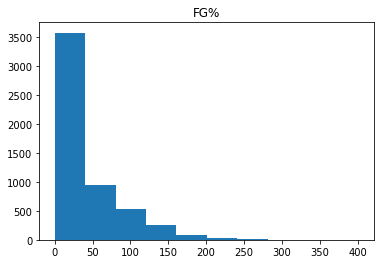

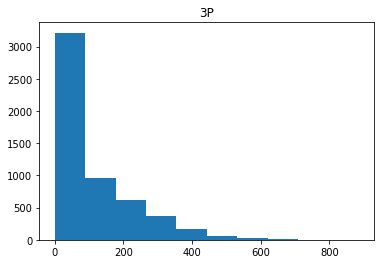

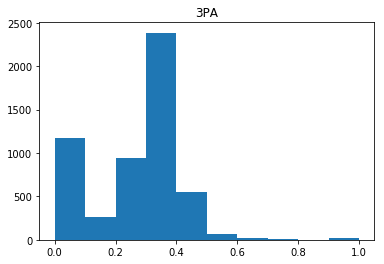

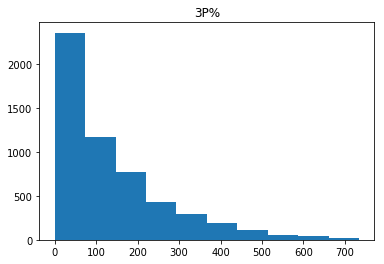

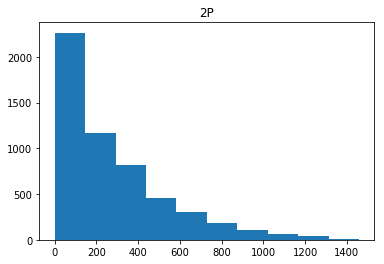

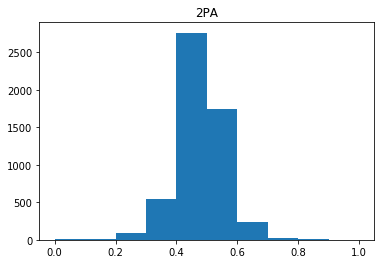

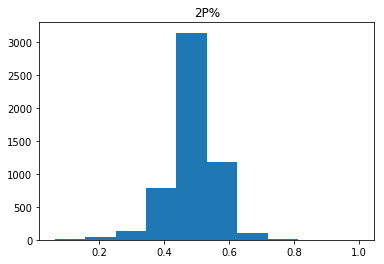

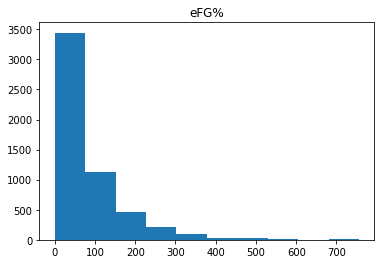

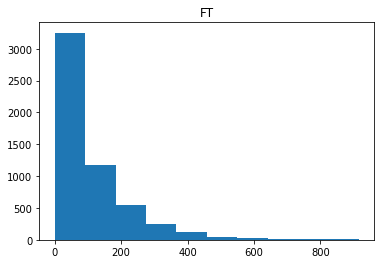

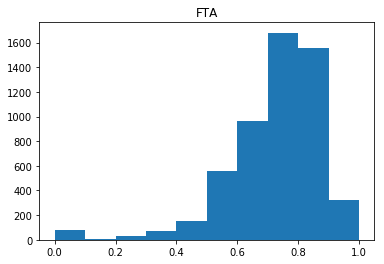

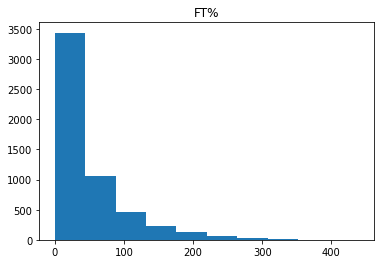

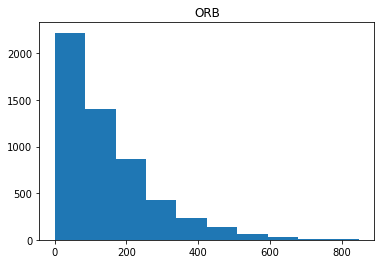

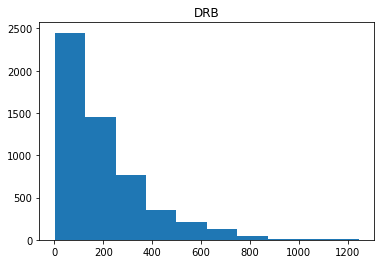

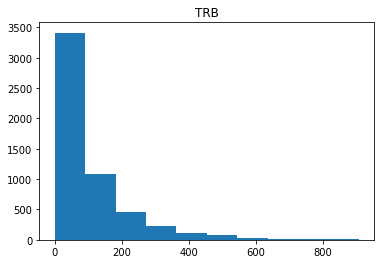

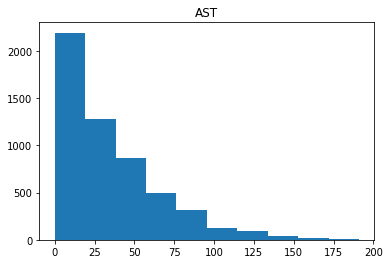

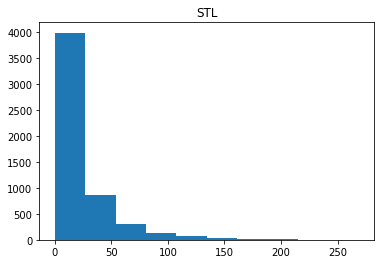

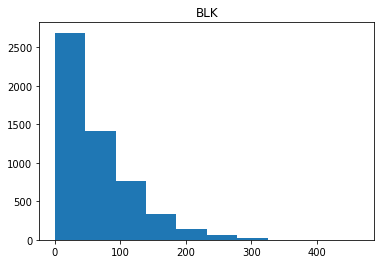

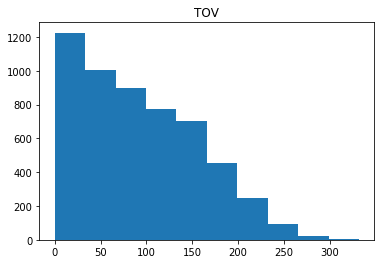

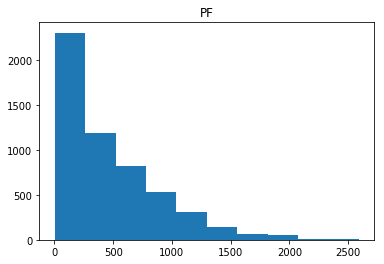

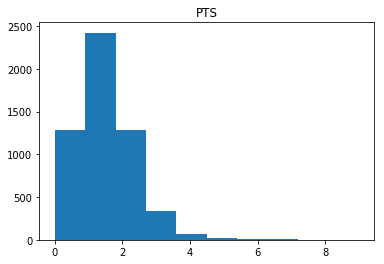

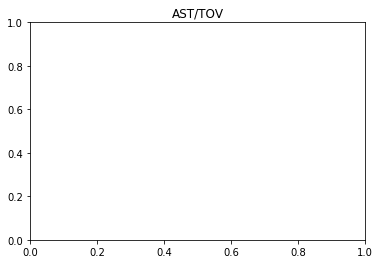

In [18]:
for x in features:
    plt.hist(data[x])
    plt.show()
    plt.title(x)

### A correlation and a heat map are good ways to check for colinearity of the features

In [19]:
data.corr()

Rk       Age         G        GS        MP        FG       FGA  \
Rk       1.000000 -0.053379 -0.037122 -0.045606 -0.045278 -0.032177 -0.030623   
Age     -0.053379  1.000000 -0.006644  0.019139  0.010943 -0.021777 -0.020097   
G       -0.037122 -0.006644  1.000000  0.613442  0.868967  0.740613  0.745313   
GS      -0.045606  0.019139  0.613442  1.000000  0.844780  0.812147  0.799916   
MP      -0.045278  0.010943  0.868967  0.844780  1.000000  0.927422  0.931561   
FG      -0.032177 -0.021777  0.740613  0.812147  0.927422  1.000000  0.988205   
FGA     -0.030623 -0.020097  0.745313  0.799916  0.931561  0.988205  1.000000   
FG%     -0.003413 -0.013198  0.240499  0.231330  0.229100  0.263385  0.169120   
3P      -0.044141  0.063049  0.508375  0.473164  0.627845  0.595454  0.663970   
3PA     -0.042563  0.051484  0.525617  0.481960  0.646167  0.611169  0.686875   
3P%     -0.018751  0.044314  0.138139  0.118395  0.204135  0.189454  0.237088   
2P      -0.022254 -0.047244  0.688031  0.783687  0.864611  0.960509  0.923018   
2PA     -0.018933 -0.049022  0.695967  0.784818  0.874860  0.962290  0.942250   
2P%     -0.011894 -0.024744  0.189794  0.175211  0.186269  0.212458  0.137362   
eFG%    -0.023918  0.055716  0.274948  0.227454  0.273507  0.271213  0.208689   
FT      -0.036845 -0.035533  0.590943  0.695626  0.790815  0.883742  0.877582   
FTA     -0.036297 -0.051153  0.609873  0.711086  0.801554  0.885214  0.868144   
FT%     -0.042800  0.072799  0.217017  0.171382  0.266264  0.272971  0.303402   
ORB     -0.041600 -0.066406  0.558840  0.566968  0.593122  0.574031  0.497689   
DRB     -0.049526  0.006548  0.712629  0.757191  0.823228  0.807248  0.761234   
TRB     -0.048916 -0.015446  0.691752  0.726837  0.783128  0.765617  0.708682   
AST      0.018435  0.046132  0.548658  0.618424  0.719058  0.709130  0.738894   
STL     -0.030065 -0.016651  0.714988  0.728394  0.856701  0.793868  0.811690   
BLK     -0.047997 -0.050068  0.495266  0.526586  0.534645  0.518267  0.449922   
TOV     -0.016735 -0.026998  0.700325  0.759713  0.869999  0.894597  0.901392   
PF      -0.047257 -0.027978  0.858520  0.725863  0.878394  0.787399  0.771431   
PTS     -0.036470 -0.016866  0.728059  0.799571  0.921826  0.991848  0.989312   
AST/TOV  0.032261  0.164293  0.036527  0.067105  0.110400  0.062799  0.099866   

              FG%        3P       3PA    ...          ORB       DRB       TRB  \
Rk      -0.003413 -0.044141 -0.042563    ...    -0.041600 -0.049526 -0.048916   
Age     -0.013198  0.063049  0.051484    ...    -0.066406  0.006548 -0.015446   
G        0.240499  0.508375  0.525617    ...     0.558840  0.712629  0.691752   
GS       0.231330  0.473164  0.481960    ...     0.566968  0.757191  0.726837   
MP       0.229100  0.627845  0.646167    ...     0.593122  0.823228  0.783128   
FG       0.263385  0.595454  0.611169    ...     0.574031  0.807248  0.765617   
FGA      0.169120  0.663970  0.686875    ...     0.497689  0.761234  0.708682   
FG%      1.000000 -0.110100 -0.139268    ...     0.471979  0.373113  0.416850   
3P      -0.110100  1.000000  0.990650    ...    -0.046011  0.308959  0.212050   
3PA     -0.139268  0.990650  1.000000    ...    -0.041309  0.320595  0.221998   
3P%     -0.212841  0.494180  0.483648    ...    -0.248143 -0.009613 -0.082656   
2P       0.345434  0.348398  0.369971    ...     0.685681  0.834843  0.819835   
2PA      0.277061  0.379281  0.403804    ...     0.645514  0.810486  0.789771   
2P%      0.822605 -0.014491 -0.019174    ...     0.325375  0.284409  0.307267   
eFG%     0.851114  0.217587  0.176466    ...     0.277058  0.301693  0.305189   
FT       0.205673  0.487528  0.510621    ...     0.485215  0.701484  0.661160   
FTA      0.253323  0.429651  0.454217    ...     0.567947  0.755232  0.725701   
FT%     -0.049621  0.356323  0.359316    ...    -0.049709  0.103227  0.060384   
ORB      0.471979 -0.046011 -0.041309    ...     1.000000  0.833460  0.914611   
DRB      0.373113  0.308959  0.320595    ... 

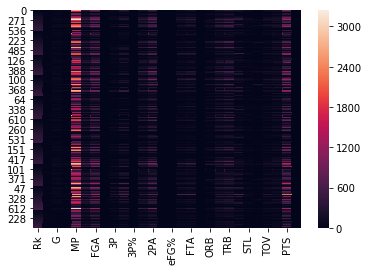

In [20]:
sns.heatmap(data);

### To account for different units of measurements between the features, I need to standardize the data to make the values not reliant on the units of measurements. I use the Min Max Scaler to do so

In [21]:
pd.set_option('display.max_columns', None)
from sklearn.preprocessing import MinMaxScaler
X = MinMaxScaler().fit_transform(data)
X2=pd.DataFrame(data = X, columns = features)
pd.DataFrame(data = X, columns = features).head(1)

Rk       Age         G        GS        MP        FG      FGA       FG%  \
0  0.0  0.217391  0.987654  0.914634  0.680978  0.316589  0.30031  0.429029   

         3P       3PA    3P%        2P       2PA    2P%      eFG%        FT  \
0  0.268657  0.281038  0.434  0.223433  0.230295  0.488  0.527215  0.095238   

        FTA    FT%       ORB       DRB       TRB      AST       STL       BLK  \
0  0.106987  0.735  0.134091  0.227594  0.201445  0.15215  0.240838  0.111524   

        TOV        PF       PTS   AST/TOV  
0  0.159483  0.677711  0.278657  0.207207

In [22]:
X.shape

(5428, 28)

## 4) Building the model

### Here, I create a new target column, where I reduce the positions down to the basic 5 positions

In [23]:
target1=[]
for x in target:
    if x == "PG" :
        target1.append('PG')
    if x == "SG" or x == "SG-PG"or x == "PG-SG" :
        target1.append('SG')
    if x == "SF" or x == "SG-SF" or x == "SF-SG":
        target1.append('SF')
    if  x == "PF"or x == "SF-PF"or x == "PF-SF"or x == "SG-PF":
        target1.append('PF')
    if x == "C" or x == "PF-C"or x == "C-PF":
        target1.append('C')
len(target1)

5428

### Here, I create a new target column, where I simplify the 5 positions to 3, in order to be able to test both targets to see which performs better.

In [24]:
simpletarget=[]
for x in target:
    if x == "SG" or x == "PG"or x == "SG-PG"or x == "PG-SG" or x == "SG-SF" or x == "SF-SG":
        simpletarget.append('G')
    if x == "SF" or x == "PF"or x == "SF-PF"or x == "PF-SF"or x == "SG-PF":
        simpletarget.append('F')
    if x == "C" or x == "PF-C"or x == "C-PF":
        simpletarget.append('F')
len(simpletarget)

5428

### In order to start modelling, I have to deal with the curse of dimensionality. Having 28 features will overcomplicate the model and add too much noise to the results. So I wil use feature selection to find the features that have the highest impact on the data, and remove the features that have low effect.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X2, target1, test_size = 0.25, random_state = 21)

In [26]:
model = ExtraTreesClassifier()
model.fit(X2, simpletarget)

print(features)
print(model.feature_importances_)


['Rk', 'Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'AST/TOV']
[0.01617924 0.02051816 0.01403464 0.01768281 0.01795193 0.01708534
 0.02352976 0.01949408 0.03058375 0.02941999 0.06428457 0.01740696
 0.01869846 0.02030357 0.02049286 0.01580866 0.01622285 0.02611423
 0.07930963 0.07408701 0.07765019 0.09968564 0.02867322 0.07976968
 0.04429003 0.0217271  0.01702649 0.07196917]


Text(0.5,1,'Feature Importance of all features')

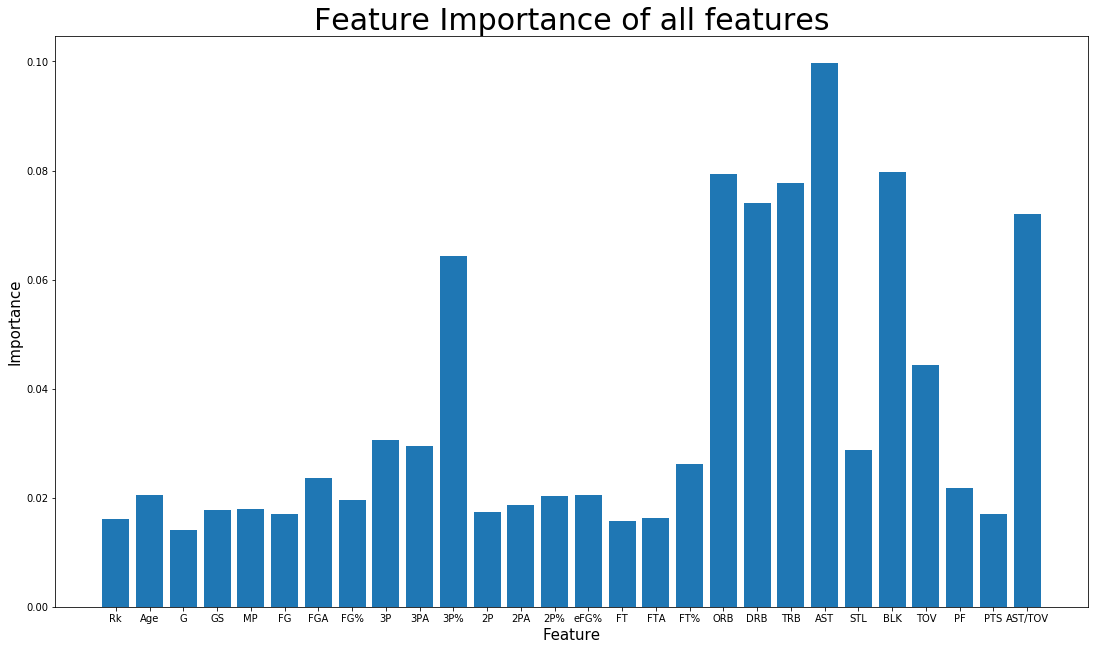

In [27]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.bar(features, model.feature_importances_)
plt.xlabel('Feature', fontsize=15)
plt.ylabel('Importance', fontsize=15)
plt.title("Feature Importance of all features", fontsize=30)

In [28]:
X_new = SelectKBest(chi2, k=10).fit_transform(X2, target1)
X_new[0]

array([0.26865672, 0.28103837, 0.434     , 0.13409091, 0.22759434,
       0.20144462, 0.15214994, 0.2408377 , 0.11152416, 0.20720721])

In [29]:
X2.head(1)

Rk       Age         G        GS        MP        FG      FGA       FG%  \
0  0.0  0.217391  0.987654  0.914634  0.680978  0.316589  0.30031  0.429029   

         3P       3PA    3P%        2P       2PA    2P%      eFG%        FT  \
0  0.268657  0.281038  0.434  0.223433  0.230295  0.488  0.527215  0.095238   

        FTA    FT%       ORB       DRB       TRB      AST       STL       BLK  \
0  0.106987  0.735  0.134091  0.227594  0.201445  0.15215  0.240838  0.111524   

        TOV        PF       PTS   AST/TOV  
0  0.159483  0.677711  0.278657  0.207207

### Based on this calculation, the feature selection process has determined that the ten most important features in predicting position:

#### 1) BLK = Blocks

#### 2) ORB = Offensive Rebounds

#### 3) AST = Assists

#### 4) 3P% = 3 Point Possession

#### 5) 3PA = 3 Point Attempts

#### 6) 3P = 3 Pointers

#### 7) TRB = Total Rebounds

#### 8) AST/TOV = Assists/Turnover Ratio

#### 9) STL = Steals

#### 10) DRB = Defensive Rebounds

### From the collinearity result and the feature selection, I found 3 significant groups that are important features but also colinear. 1 (ORB, DRB, TRB, partiallyBLK) 2(3PA, 3P%, 3P) 3(STL, AST, AST/TOV). So i use one from each group to create the new set of data with the important features

In [30]:
df2= X2[['ORB', 'AST', '3P%']]
df3= X2[['BLK','ORB', 'AST', '3P%']]

### Now to start my first model, an XGBoost based on the 3 feature - 5 position data

In [31]:
X_train, X_test, y_train, y_test = train_test_split(df2, target1)
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train)
training_preds = clf.predict(X_train)
val_preds = clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

Training Accuracy: 60.67%
Validation accuracy: 54.97%


C:\Users\Brian\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Brian\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### The second model will be a Decision Tree Classifier based on 3 feature - 5 position data

In [32]:
dt_clf = DecisionTreeClassifier()
dt_cv_score = cross_val_score(dt_clf, df2, target1, cv=3)
mean_dt_cv_score = np.mean(dt_cv_score)

print("Mean Cross Validation Score: {:.4}%".format(mean_dt_cv_score * 100))

Mean Cross Validation Score: 43.9%


### Now I start a GridSearchCV based on 3 feature - 5 postion data

In [33]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
}
dt_grid_search = GridSearchCV(dt_clf, dt_param_grid, cv=3, return_train_score=True)
dt_grid_search.fit(df2, target1)
GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [None, 2, 3, 4, 5, 6], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 3, 4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [None, 2, 3, 4, 5, 6], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 3, 4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [34]:
dt_gs_training_score = np.mean(dt_grid_search.cv_results_['mean_train_score'])
dt_gs_testing_score = dt_grid_search.score(df2, target1)

print("Mean Training Score: {:.4}%".format(dt_gs_training_score * 100))
print("Mean Testing Score: {:.4}%".format(dt_gs_testing_score * 100))
print("Best Parameter Combination Found During Grid Search:")
dt_grid_search.best_params_

Mean Training Score: 51.86%
Mean Testing Score: 54.77%
Best Parameter Combination Found During Grid Search:


{'criterion': 'entropy',
 'max_depth': 6,
 'min_samples_leaf': 2,
 'min_samples_split': 2}

### Now to run a ADABoost based on 3 feature - 5 postion data

In [35]:
adaboost_clf = AdaBoostClassifier()
adaboost_mean_cv_score = np.mean(cross_val_score(adaboost_clf, df2, target1, cv=3))

print("Mean Cross Validation Score for AdaBoost: {:.4}%".format(adaboost_mean_cv_score * 100))

Mean Cross Validation Score for AdaBoost: 50.87%


In [36]:
adaboost_param_grid = {
    'n_estimators': [50, 100, 250],
    'learning_rate': [1.0, 0.5, 0.1]
}

In [37]:
adaboost_grid_search = GridSearchCV(adaboost_clf, adaboost_param_grid, cv=3)
adaboost_grid_search.fit(df2, target1)

print("Testing Accuracy: {:.4}%".format(adaboost_grid_search.best_score_ * 100))
print("Optimal Parameters: {}".format(adaboost_grid_search.best_params_))

Testing Accuracy: 52.51%
Optimal Parameters: {'learning_rate': 0.5, 'n_estimators': 100}


### This time, a Bagged Tree Classifier based on 3 feature - 5 position data

In [38]:
data_train, data_test, target_train, target_test = train_test_split(df2, target1, 
                                                                   test_size = 0.25, random_state=123)


In [39]:
bagged_tree =  BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth=5), n_estimators=20)

In [40]:
bagged_tree.fit(data_train, target_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=20, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [41]:
bagged_tree.score(data_train, target_train)

0.5428641611397691

### And lastly, a Random Forrest Classifier based on 3 feature- 5 position data

In [42]:
forest = RandomForestClassifier(n_estimators=100, max_depth= 5)
forest.fit(data_train, target_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [43]:
forest.score(data_train, target_train)

0.5514615573569147

In [44]:
forest.score(data_test, target_test)

0.49815770081061167

### Now to move on to the 3 position classification: Guard, Forwrd, Center

### To start with this data, I use the XGBoost based on 3 feature- 3 position data

In [45]:
X_train, X_test, y_train, y_test = train_test_split(df2, simpletarget)

In [46]:
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train)
training_preds = clf.predict(X_train)
val_preds = clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

Training Accuracy: 86.29%
Validation accuracy: 85.7%


C:\Users\Brian\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Brian\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### Next, Decision Tree Classifier on 3 feature - 3 position data

In [47]:
dt_clf = DecisionTreeClassifier()
dt_cv_score = cross_val_score(dt_clf, df2, simpletarget, cv=3)
mean_dt_cv_score = np.mean(dt_cv_score)

print("Mean Cross Validation Score: {:.4}%".format(mean_dt_cv_score * 100))

Mean Cross Validation Score: 79.7%


### Then, GridSearchCV on 3 feature - 3 position data

In [48]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
}
dt_grid_search = GridSearchCV(dt_clf, dt_param_grid, cv=3, return_train_score=True)
dt_grid_search.fit(df2, simpletarget)
GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [None, 2, 3, 4, 5, 6], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 3, 4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [None, 2, 3, 4, 5, 6], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 3, 4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [49]:
dt_gs_training_score = np.mean(dt_grid_search.cv_results_['mean_train_score'])
dt_gs_testing_score = dt_grid_search.score(df2, simpletarget)

print("Mean Training Score: {:.4}%".format(dt_gs_training_score * 100))
print("Mean Testing Score: {:.4}%".format(dt_gs_testing_score * 100))
print("Best Parameter Combination Found During Grid Search:")
dt_grid_search.best_params_

Mean Training Score: 82.22%
Mean Testing Score: 86.53%
Best Parameter Combination Found During Grid Search:


{'criterion': 'gini',
 'max_depth': 6,
 'min_samples_leaf': 2,
 'min_samples_split': 2}

### Now to run a ADABoost based on 3 feature - 3 postion data

In [50]:
adaboost_param_grid = {
    'n_estimators': [50, 100, 250],
    'learning_rate': [1.0, 0.5, 0.1]
}

In [51]:
adaboost_grid_search = GridSearchCV(adaboost_clf, adaboost_param_grid, cv=3)
adaboost_grid_search.fit(df2, simpletarget)

print("Testing Accuracy: {:.4}%".format(adaboost_grid_search.best_score_ * 100))
print("Optimal Parameters: {}".format(adaboost_grid_search.best_params_))

Testing Accuracy: 84.69%
Optimal Parameters: {'learning_rate': 0.5, 'n_estimators': 250}


### This time, a Bagged Tree Classifier based on 3 feature - 3 position data

In [52]:
data_train, data_test, target_train, target_test = train_test_split(df2, simpletarget, 
                                                                   test_size = 0.25, random_state=123)


In [53]:
bagged_tree =  BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth=5), n_estimators=20)

In [54]:
bagged_tree.fit(data_train, target_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=20, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [55]:
bagged_tree.score(data_train, target_train)

0.8703021370670597

### And lastly, a Random Forrest Classifier based on 3 feature- 3 position data

In [56]:
forest = RandomForestClassifier(n_estimators=100, max_depth= 5)
forest.fit(data_train, target_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [57]:
forest.score(data_train, target_train)

0.8599852616064849

In [58]:
forest.score(data_test, target_test)

0.840825350036846

# Conclusion

### It seems like the classifier is much more accurate when trying to classify into three positions than 5. The 5 poistion classifier performs around 30% better on average then a random guess. The three position classifier performs on average around 50% better than random selection.

In [59]:
tests=["XGBoost", "Decision Tree", "GridSearchCV", "ADABoost", "Bagged Tree", "Random FOrret"]
pos= ['Random Guess', 'Classifier', 'Perfect']

results3XG=[.3333, .8607, 1]
results5XG=[.2,.5453,  1]

results3DT=[.3333, .7946, 1]
results5DT=[.2,.4383,  1]

results3GS=[.3333, .8653, 1]
results5GS=[.2,.5468,  1]

results3AD=[.3333, .8703, 1]
results5AD=[.2,.5087,  1]

results3BT=[.3333, .8469, 1]
results5BT=[.2,.5377,  1]

results3RF=[.3333, .8432, 1]
results5RF=[.2,.5551,  1]

Text(0.5,1,'XGBoost 3 position classifier')

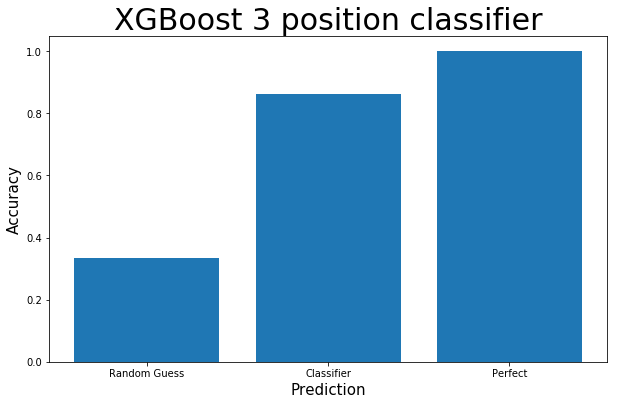

In [60]:
fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.bar(pos,results3XG )
plt.xlabel('Prediction', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.title('XGBoost 3 position classifier', fontsize=30)

Text(0.5,1,'XGBoost 5 position classifier')

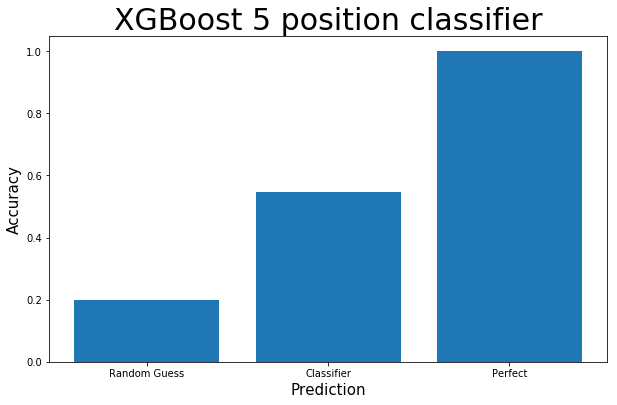

In [61]:
fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.bar(pos,results5XG )
plt.xlabel('Prediction', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.title('XGBoost 5 position classifier', fontsize=30)

Text(0.5,1,'Decision Tree 3 position classifier')

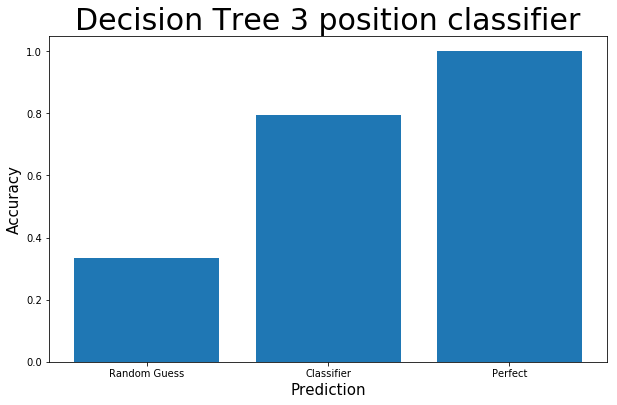

In [62]:
fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.bar(pos,results3DT )
plt.xlabel('Prediction', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.title('Decision Tree 3 position classifier', fontsize=30)

Text(0.5,1,'Decision Tree 5 position classifier')

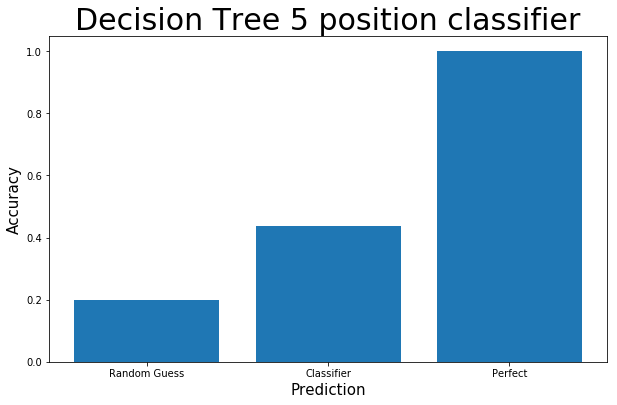

In [63]:
fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.bar(pos,results5DT )
plt.xlabel('Prediction', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.title('Decision Tree 5 position classifier', fontsize=30)

Text(0.5,1,'GridSearchCV 3 position classifier')

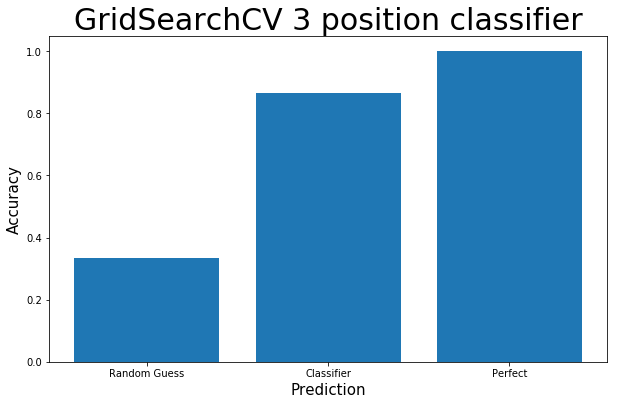

In [64]:
fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.bar(pos,results3GS )
plt.xlabel('Prediction', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.title('GridSearchCV 3 position classifier', fontsize=30)

Text(0.5,1,'GridSearchCV 5 position classifier')

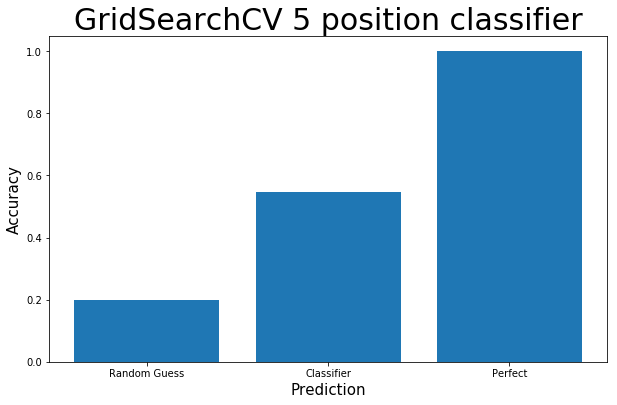

In [65]:
fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.bar(pos,results5GS )
plt.xlabel('Prediction', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.title('GridSearchCV 5 position classifier', fontsize=30)

Text(0.5,1,'ADABoost 3 position classifier')

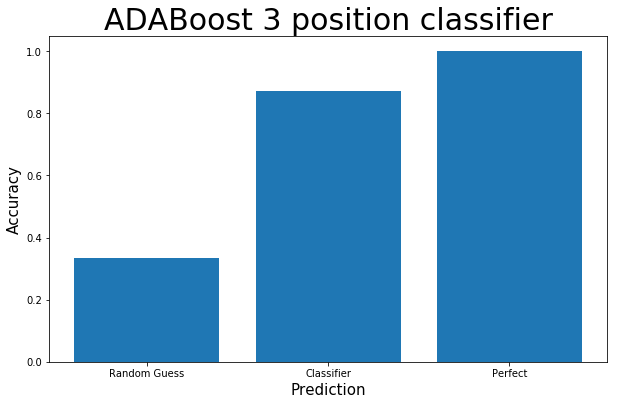

In [66]:
fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.bar(pos,results3AD )
plt.xlabel('Prediction', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.title('ADABoost 3 position classifier', fontsize=30)

Text(0.5,1,'ADABoost 5 position classifier')

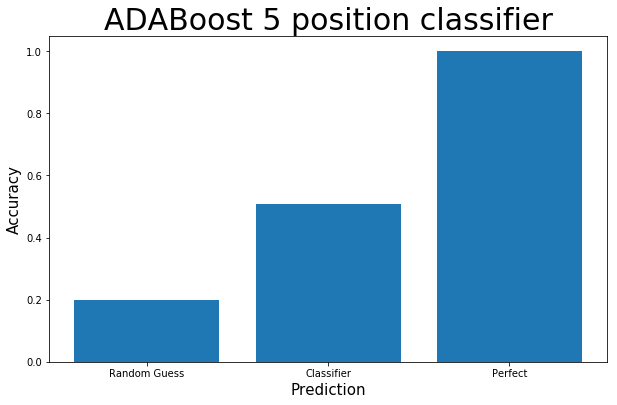

In [67]:
fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.bar(pos,results5AD )
plt.xlabel('Prediction', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.title('ADABoost 5 position classifier', fontsize=30)

Text(0.5,1,'Bagged Tree 3 position classifier')

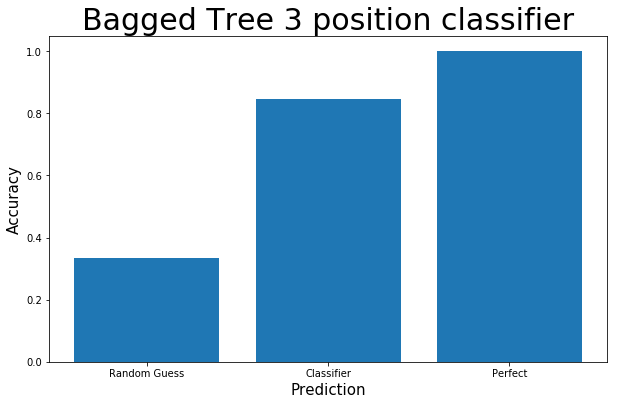

In [68]:
fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.bar(pos,results3BT )
plt.xlabel('Prediction', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.title('Bagged Tree 3 position classifier', fontsize=30)

Text(0.5,1,'Bagged Tree 5 position classifier')

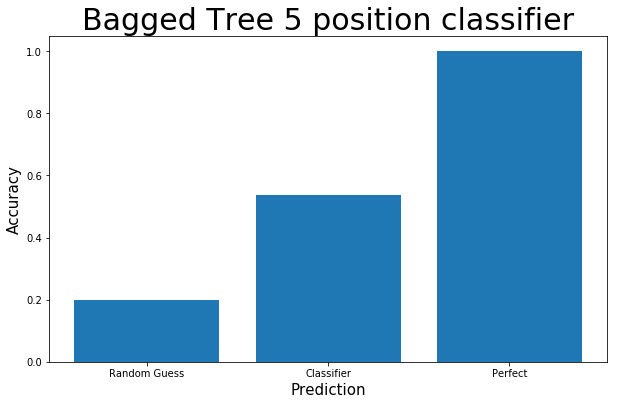

In [69]:
fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.bar(pos,results5BT )
plt.xlabel('Prediction', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.title('Bagged Tree 5 position classifier', fontsize=30)

Text(0.5,1,'Random Forrest 3 position classifier')

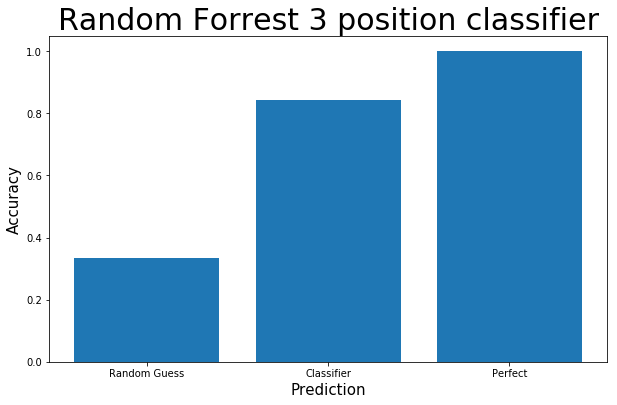

In [70]:
fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.bar(pos,results3RF )
plt.xlabel('Prediction', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.title('Random Forrest 3 position classifier', fontsize=30)

Text(0.5,1,'Random Forrest 5 position classifier')

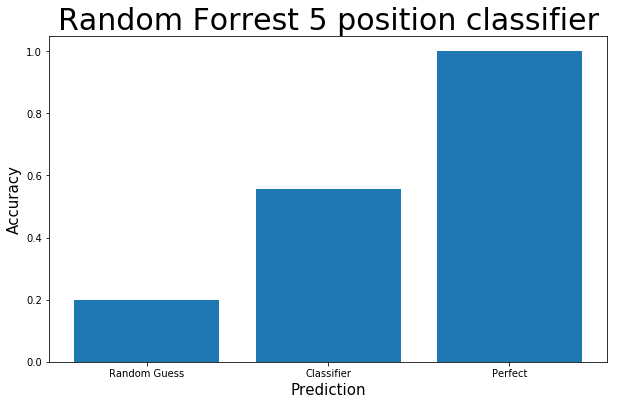

In [71]:
fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.bar(pos,results5RF )
plt.xlabel('Prediction', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.title('Random Forrest 5 position classifier', fontsize=30)

In [80]:
y_pred= adaboost_grid_search.predict(df2)
cm1= (confusion_matrix(simpletarget, y_pred))

In [83]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

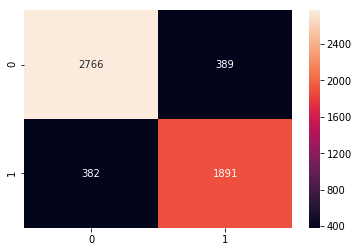

In [97]:
sns.heatmap(cm1, annot=True, fmt="d",xticklabels=1, yticklabels=1)